Random vectors with mean vector [1, 2] and covariance matrix:
[[1, 0], [0, 10]]

[[ 0.5538853   5.20862348]
 [ 0.68484511 -0.72641813]
 [ 0.28364255  0.28079196]
 ...
 [ 4.46463508  2.87885029]
 [ 4.77413845  3.95193142]
 [ 5.25194529  2.28603474]]

Sample mean:
[2.33162026 2.32518827]

Sample covariance matrix:
[[4.56537939 1.2422118 ]
 [1.2422118  7.54990605]]



<Axes: >

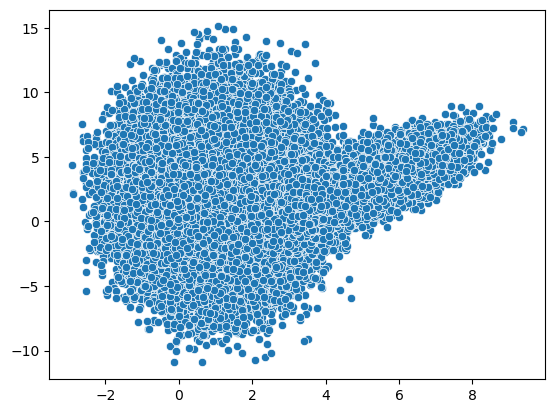

In [73]:
import numpy as np
import seaborn
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import logsumexp

# Set the dimension, mean vector, and covariance matrix
sampleSize = 100000

weight1 = 0.5
mean1 = [1, 2]
cov1 = [[1, 0], [0, 10]]

weight2 = 0.5
mean2 = [5, 3]
cov2 = [[1, 1], [1, 2]]

# Generate a sample set of random vectors
samples1 = np.random.multivariate_normal(mean1, cov1, sampleSize)
samples2 = np.random.multivariate_normal(mean2, cov2, int(sampleSize/2))

#samples = weight1*samples1+weight2*samples2
samples = np.concatenate((samples1, samples2), axis=0)

print(f"Random vectors with mean vector {mean1} and covariance matrix:\n{cov1}\n")
print(f"{samples}\n")

sample_mean = np.mean(samples, axis=0)
sample_cov = np.cov(samples.T)

print(f"Sample mean:\n{sample_mean}\n")
print(f"Sample covariance matrix:\n{sample_cov}\n")

#seaborn.scatterplot(x=samples1[:,0],y=samples1[:,1])
#seaborn.scatterplot(x=samples2[:,0],y=samples2[:,1])
seaborn.scatterplot(x=samples[:,0],y=samples[:,1])

In [74]:
int(sampleSize/2)

50000

In [75]:
# EM Algorithm

x_unlabeled = samples

def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

def e_step(x, params):
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x_unlabeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(x_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

random_params = initialize_random_params()
unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_unlabeled, random_params)
print("total steps: ", len(unsupervised_loglikelihoods))
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.savefig("unsupervised.png")
plt.close()



/var/folders/8g/zrqn7yqx5yvgtqtt793z3p5m0000gn/T/ipykernel_67234/3470044504.py:19: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
/var/folders/8g/zrqn7yqx5yvgtqtt793z3p5m0000gn/T/ipykernel_67234/3470044504.py:22: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),


	phi: 0.6654911469589165
	mu_0: [4.99617173 2.99646298]
	mu_1: [0.99228456 1.98777232]
	sigma_0: [[1.01292299 1.02004459]
 [1.02004459 2.02455563]]
	sigma_1: [[9.88425369e-01 2.89618887e-03]
 [2.89618887e-03 9.98679723e+00]]
total steps:  25


In [19]:
def EM():

    params = 1
    return params

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [39]:
import numpy as np                              # import numpy
from numpy.linalg import inv                    # for matrix inverse
import matplotlib.pyplot as plt                 # import matplotlib.pyplot for plotting framework
from scipy.stats import multivariate_normal     # for generating pdf
import random

In [40]:
m1 = [1,1]      # consider a random mean and covariance value
m2 = [7,7]                                              
cov1 = [[3, 2], [2, 3]]                                      
cov2 = [[2, -1], [-1, 2]]
x = np.random.multivariate_normal(m1, cov1, size=(200,))  # Generating 200 samples for each mean and covariance
y = np.random.multivariate_normal(m2, cov2, size=(200,))
d = np.concatenate((x, y), axis=0)

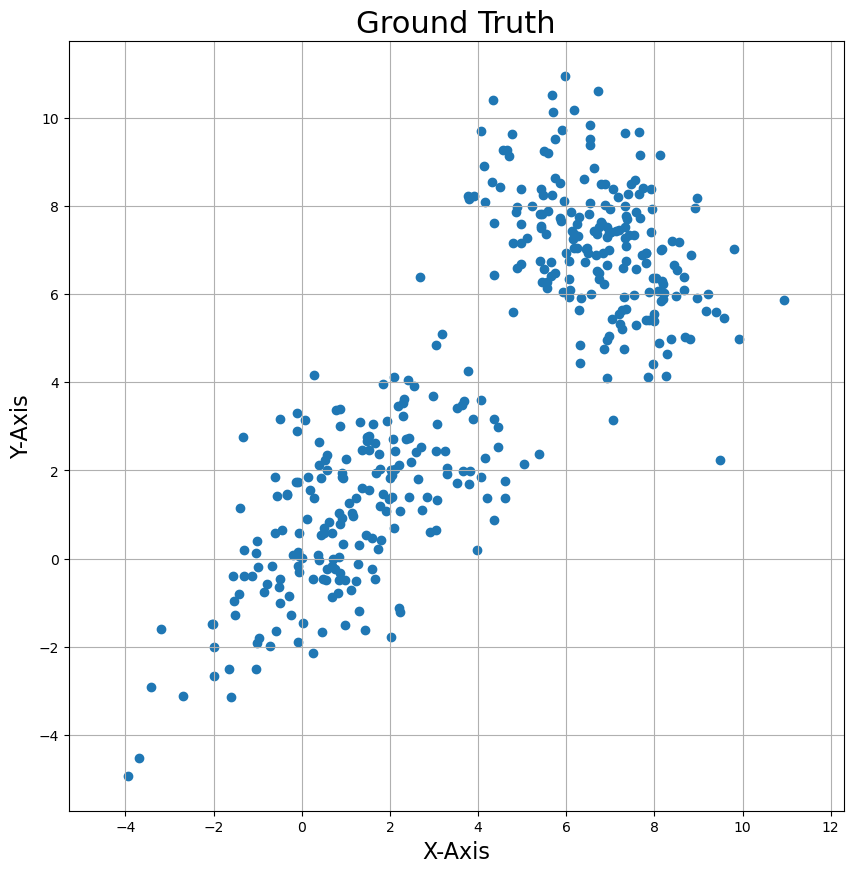

In [51]:
plt.figure(figsize=(10,10))                                 
plt.scatter(d[:,0], d[:,1], marker='o')     
plt.axis('equal')                                  
plt.xlabel('X-Axis', fontsize=16)              
plt.ylabel('Y-Axis', fontsize=16)                     
plt.title('Ground Truth', fontsize=22)    
plt.grid()            
plt.show()

In [49]:
m1 = random.choice(d)
m2 = random.choice(d)
cov1 = np.cov(np.transpose(d))
cov2 = np.cov(np.transpose(d))
pi = 0.5

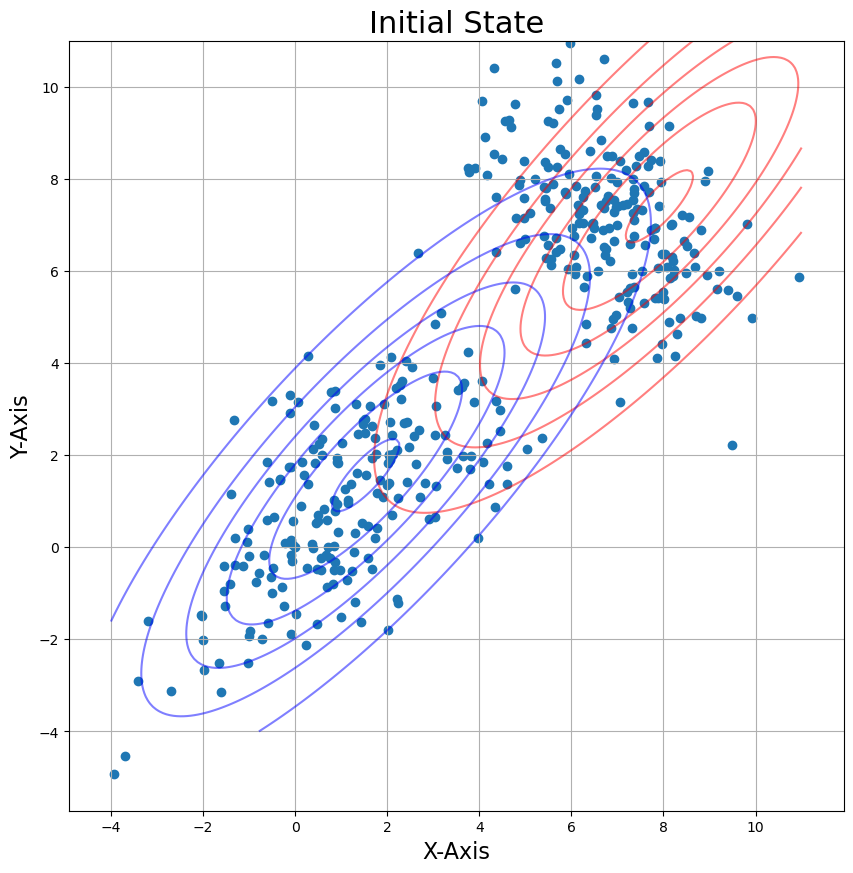

In [50]:
x1 = np.linspace(-4,11,200)  
x2 = np.linspace(-4,11,200)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(d[:,0], d[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('X-Axis', fontsize=16)                                                  # X-Axis
plt.ylabel('Y-Axis', fontsize=16)                                                  # Y-Axis
plt.title('Initial State', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [44]:
##Expectation step
def Estep(lis1):
    m1=lis1[0]
    m2=lis1[1]
    cov1=lis1[2]
    cov2=lis1[3]
    pi=lis1[4]
    
    pt2 = multivariate_normal.pdf(d, mean=m2, cov=cov2)
    pt1 = multivariate_normal.pdf(d, mean=m1, cov=cov1)
    w1 = pi * pt2
    w2 = (1-pi) * pt1
    eval1 = w1/(w1+w2)

    return(eval1)

## Maximization step
def Mstep(eval1):
    num_mu1,din_mu1,num_mu2,din_mu2=0,0,0,0

    for i in range(0,len(d)):
        num_mu1 += (1-eval1[i]) * d[i]
        din_mu1 += (1-eval1[i])

        num_mu2 += eval1[i] * d[i]
        din_mu2 += eval1[i]

    mu1 = num_mu1/din_mu1
    mu2 = num_mu2/din_mu2

    num_s1,din_s1,num_s2,din_s2=0,0,0,0
    for i in range(0,len(d)):

        q1 = np.matrix(d[i]-mu1)
        num_s1 += (1-eval1[i]) * np.dot(q1.T, q1)
        din_s1 += (1-eval1[i])

        q2 = np.matrix(d[i]-mu2)
        num_s2 += eval1[i] * np.dot(q2.T, q2)
        din_s2 += eval1[i]

    s1 = num_s1/din_s1
    s2 = num_s2/din_s2

    pi = sum(eval1)/len(d)
    
    lis2=[mu1,mu2,s1,s2,pi]
    return(lis2)

def plot(lis1):
    mu1=lis1[0]
    mu2=lis1[1]
    s1=lis1[2]
    s2=lis1[3]
    Z1 = multivariate_normal(mu1, s1)  
    Z2 = multivariate_normal(mu2, s2)

    pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
    pos[:, :, 0] = X; pos[:, :, 1] = Y   

    plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
    plt.scatter(d[:,0], d[:,1], marker='o')     
    plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
    plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
    plt.axis('equal')                                                                  # making both the axis equal
    plt.xlabel('X-Axis', fontsize=16)                                                  # X-Axis
    plt.ylabel('Y-Axis', fontsize=16)                                                  # Y-Axis
    plt.grid()                                                                         # displaying gridlines
    plt.show()

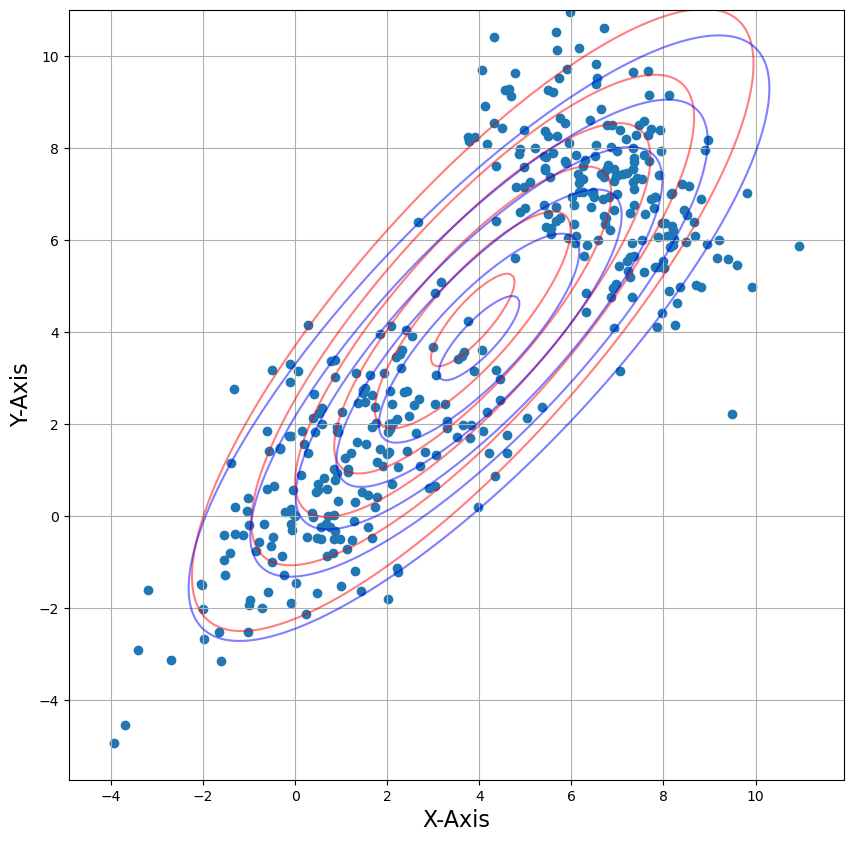

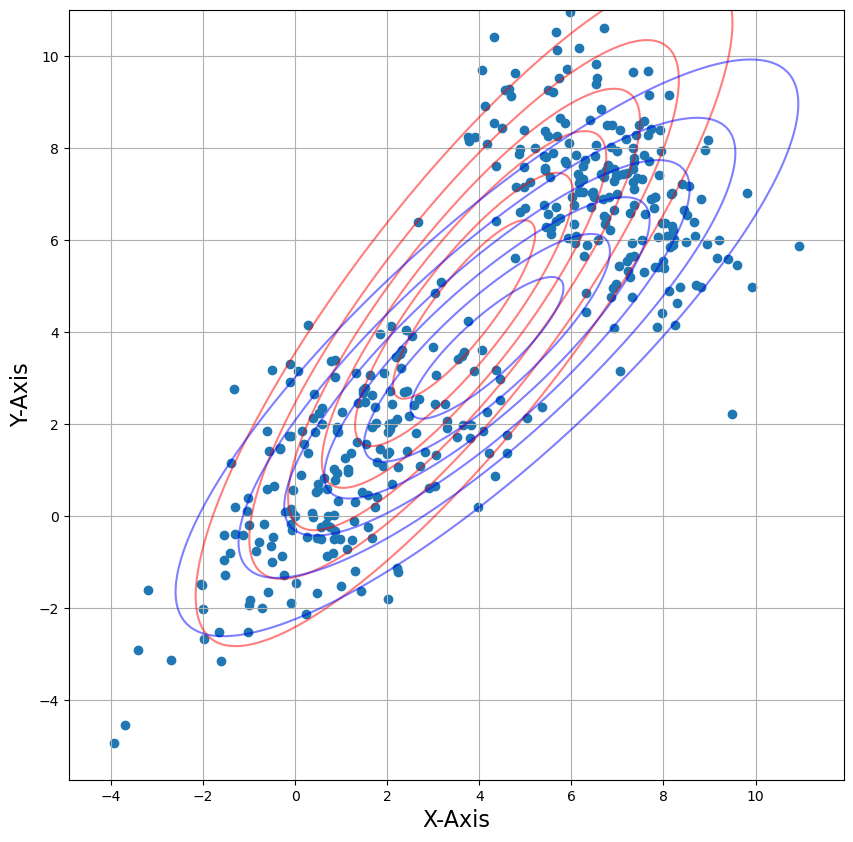

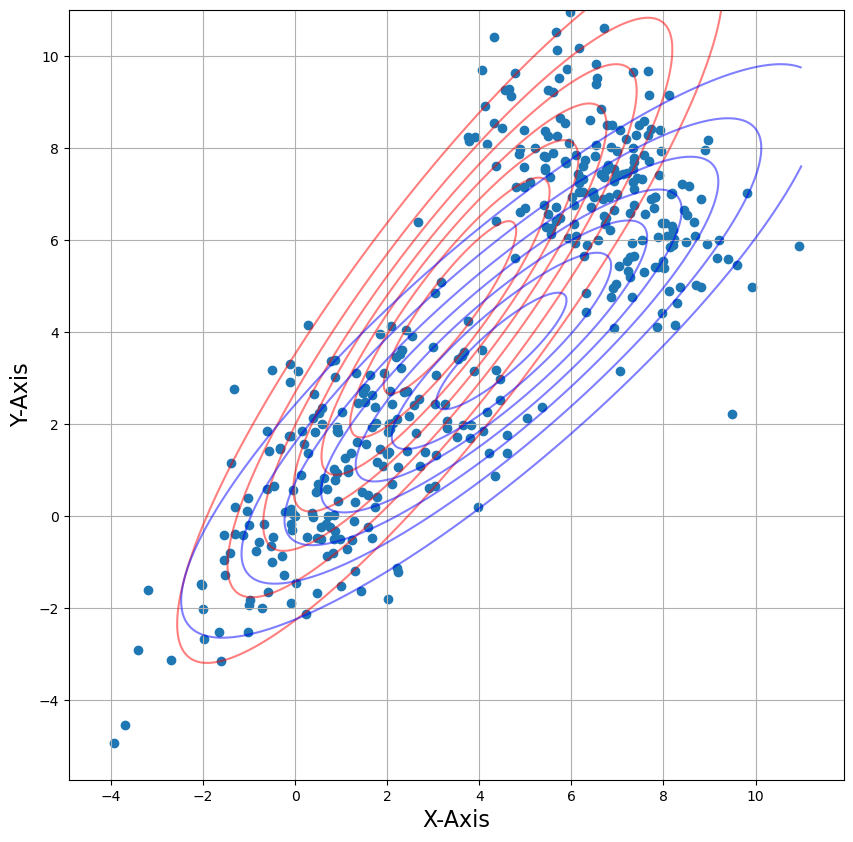

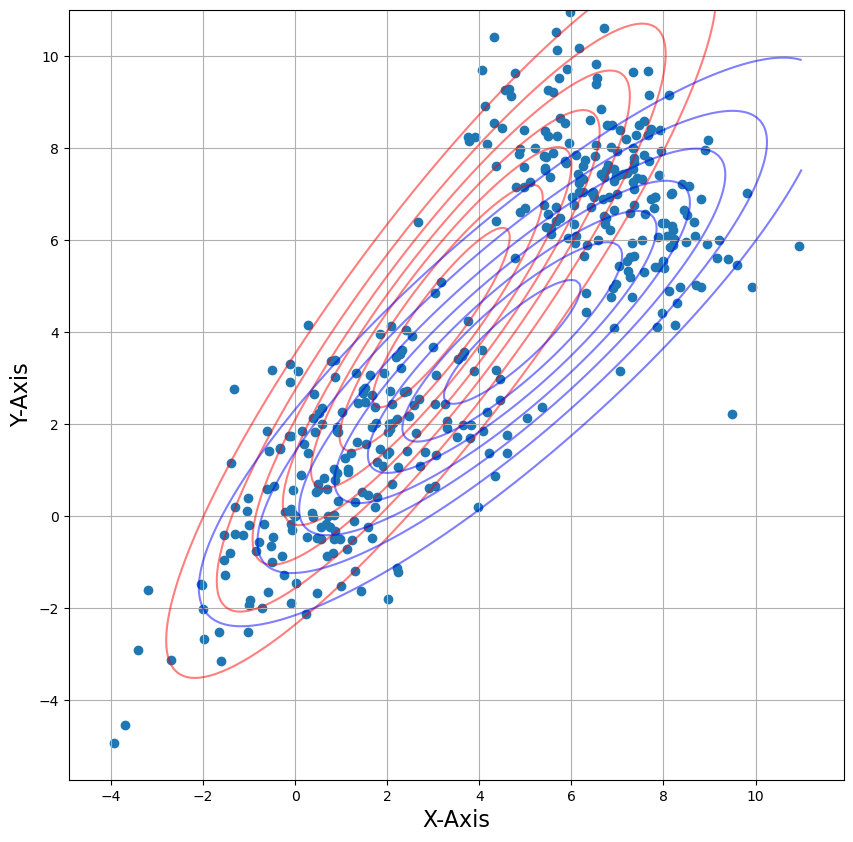

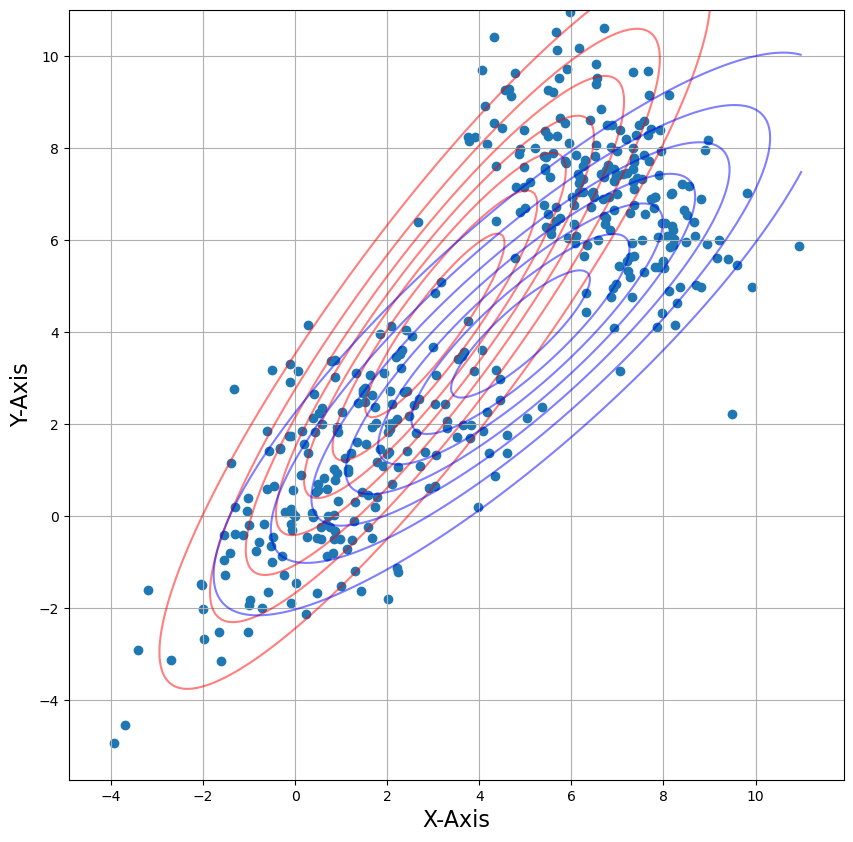

In [47]:
iterations = 30
lis1=[m1,m2,cov1,cov2,pi]
for i in range(0,iterations):
    lis2 = Mstep(Estep(lis1))
    lis1=lis2
    if(i==0 or i == 5 or i == 15 or i == 24 or i == 29):
        plot(lis1)